### Установка всех необходимых библиотек

In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install stanza

clear_output()

In [ ]:
%pip install bert_score

clear_output()

In [ ]:
%pip install transformers

clear_output()

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.stats
import tensorflow_hub as hub
from tqdm import tqdm
import stanza
from bert_score import score
from scipy import spatial
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction


In [ ]:
stanza.download('ru')
clear_output()

### Скачивание текстов, анализ результатов разметки (анализ корреляции), создание таблицы для вычисления признаков

In [ ]:
marked_paragraphs = pd.read_csv("/content/marked_paragraphs.csv")

In [ ]:
marked_paragraphs['familiar_mean'] = marked_paragraphs[['familiar_1', 'familiar_2', 'familiar_3']].mean(axis=1)
marked_paragraphs['understandable_mean'] = marked_paragraphs[['understandable_1', 'understandable_2', 'understandable_3']].mean(axis=1)
marked_paragraphs['word_coherence_mean'] = marked_paragraphs[['word_coherence_1', 'word_coherence_2', 'word_coherence_3']].mean(axis=1)
marked_paragraphs['coherence_mean'] = marked_paragraphs[['coherence_1', 'coherence_2', 'coherence_3']].mean(axis=1)
marked_paragraphs['syntax_compl_mean'] = marked_paragraphs[['syntax_compl_1', 'syntax_compl_2', 'syntax_compl_3']].mean(axis=1)
marked_paragraphs['complexity_mean'] = marked_paragraphs[['complexity_1', 'complexity_2', 'complexity_3']].mean(axis=1)

In [ ]:
marked_paragraphs.head()

,paragraph,familiar_1,understandable_1,word_coherence_1,coherence_1,syntax_compl_1,complexity_1,familiar_2,understandable_2,word_coherence_2,...,word_coherence_3,coherence_3,syntax_compl_3,complexity_3,familiar_mean,understandable_mean,word_coherence_mean,coherence_mean,syntax_compl_mean,complexity_mean
0,"Внутренней называется память, встроенная в ком...",5,5,5,5,2,2,5,5,5,...,5,5,2,1,5.000000,5.000000,5.000000,5.000000,2.666667,2.000000
1,Содержащиеся в документах таблицы часто формир...,4,3,5,4,3,3,4,5,5,...,5,4,3,3,4.000000,4.000000,5.000000,4.333333,3.000000,2.666667
2,Особенно широкую популярность персональные ком...,5,5,5,5,2,2,4,5,5,...,5,5,3,2,4.666667,5.000000,5.000000,5.000000,2.333333,1.666667
3,"Параметры режима работы энергообъекта, отображ...",2,2,3,3,4,4,1,3,5,...,3,4,4,3,2.000000,2.666667,3.666667,4.000000,3.666667,3.666667
4,Экспертные системы. Предназначены для анализа ...,5,5,2,4,3,3,5,5,5,...,5,5,2,2,5.000000,5.000000,4.000000,4.666667,2.666667,2.000000


In [ ]:
def compute_correlation(feats, data):
    corr = pd.DataFrame(
        columns=list(feats),
        index=list(feats)
    )
    for feat_1 in feats:
      for feat_2 in feats:
        if feat_1 == feat_2:
          corr_val = 1
        else:
          corr_val = scipy.stats.pearsonr(data[feat_1], data[feat_2])[0]
        corr.at[feat_1, feat_2] = corr_val
    return corr

Посчитаем внутриэкспертное соглашение

In [ ]:
feats = ['familiar_1', 'familiar_2', 'familiar_3', ]
corr_fam = compute_correlation(feats, marked_paragraphs)

feats = ['understandable_1', 'understandable_2', 'understandable_3', ]
corr_und = compute_correlation(feats, marked_paragraphs)

feats = ['word_coherence_1', 'word_coherence_2', 'word_coherence_3', ]
corr_wcoh = compute_correlation(feats, marked_paragraphs)

feats = ['coherence_1', 'coherence_2', 'coherence_3', ]
corr_coh = compute_correlation(feats, marked_paragraphs)

feats = ['syntax_compl_1', 'syntax_compl_2', 'syntax_compl_3', ]
corr_synt = compute_correlation(feats, marked_paragraphs)

feats = ['complexity_1', 'complexity_2', 'complexity_3', ]
corr_compl = compute_correlation(feats, marked_paragraphs)

corr_fam, corr_und, corr_wcoh, corr_coh, corr_synt, corr_compl

(           familiar_1 familiar_2 familiar_3
 familiar_1          1    0.55715   0.543054
 familiar_2    0.55715          1   0.447121
 familiar_3   0.543054   0.447121          1,
                  understandable_1 understandable_2 understandable_3
 understandable_1                1         0.270475         0.488605
 understandable_2         0.270475                1         0.240581
 understandable_3         0.488605         0.240581                1,
                  word_coherence_1 word_coherence_2 word_coherence_3
 word_coherence_1                1         0.262326         0.355224
 word_coherence_2         0.262326                1         0.283609
 word_coherence_3         0.355224         0.283609                1,
             coherence_1 coherence_2 coherence_3
 coherence_1           1    0.146262    0.268704
 coherence_2    0.146262           1   -0.011475
 coherence_3    0.268704   -0.011475           1,
                syntax_compl_1 syntax_compl_2 syntax_compl_3
 syntax

In [ ]:
feats = ['familiar_mean', 'understandable_mean', 'word_coherence_mean', 'coherence_mean', 'syntax_compl_mean', 'complexity_mean',]
corr = compute_correlation(feats, marked_paragraphs)
corr

,familiar_mean,understandable_mean,word_coherence_mean,coherence_mean,syntax_compl_mean,complexity_mean
familiar_mean,1,0.724695,0.153508,0.34351,-0.377621,-0.69807
understandable_mean,0.724695,1,0.157436,0.433765,-0.428699,-0.772527
word_coherence_mean,0.153508,0.157436,1,0.510392,-0.085974,-0.142291
coherence_mean,0.34351,0.433765,0.510392,1,-0.153271,-0.337906
syntax_compl_mean,-0.377621,-0.428699,-0.085974,-0.153271,1,0.651732
complexity_mean,-0.69807,-0.772527,-0.142291,-0.337906,0.651732,1


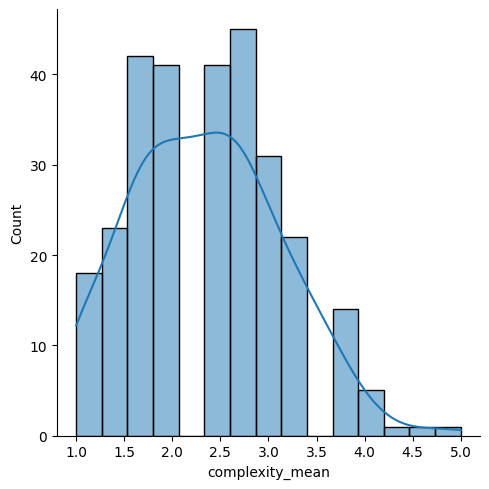

In [ ]:
import seaborn as sns

#create histogram with density curve overlaid
sns.displot(marked_paragraphs["complexity_mean"], kde=True, bins=15)

In [ ]:
feats_table = pd.DataFrame(columns=[
    "paragraph", "complexity_mean", "length_tokens", "noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num",
    "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs",
])

In [ ]:
feats_table["paragraph"] = marked_paragraphs["paragraph"]
feats_table["complexity_mean"] = marked_paragraphs["complexity_mean"]

In [ ]:
feats_table["length_tokens"] = marked_paragraphs["paragraph"].map(lambda x: len(x.split()))
print(f"Среднее количество токенов текста: {feats_table['length_tokens'].mean()}")
print(f"Максимальное количество токенов текста: {feats_table['length_tokens'].max()}")
print(f"Минимальное количество токенов текста: {feats_table['length_tokens'].min()}")

Среднее количество токенов текста: 75.02105263157895
Максимальное количество токенов текста: 144
Минимальное количество токенов текста: 29


In [ ]:
# elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [ ]:
!wget http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz

import tarfile

with tarfile.open("/content/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz", 'r') as tar:
    tar.extractall("/content/elmo")

clear_output()

In [ ]:
elmo = tf.saved_model.load("/content/elmo/")
clear_output()

In [ ]:
stanza_proc = stanza.Pipeline(lang='ru', processors='tokenize,pos,lemma,depparse')

clear_output()

### Функции для вычисления признаков

In [ ]:
def compute_tree_height(deps, cur_node, height):
  if not deps[cur_node]:
    return height + 1
  else:
    res_height = height
    for node in deps[cur_node]:
      cur_height = compute_tree_height(deps, node, height + 1)
      if cur_height > res_height:
        res_height = cur_height
    return res_height

In [ ]:
def compute_syntax_features(paragraph):
  max_height, mean_height, mean_leaves, mean_parts_num = 0, 0, 0, 0
  pos = {"noun": 0, "verb": 0, "adj": 0, "adv": 0, "part": 0, "adv_part": 0, "pron": 0}
  clean_paragraph = []
  for sent in paragraph:
    clean_sent = ''
    doc = stanza_proc(sent)
    deps = {key: [] for key in range(1, len(doc.sentences[0].words) + 1)}
    root = -1
    for word in doc.sentences[0].words:
      if word.deprel == 'root':
        root = word.id
      # print(word)
      if word.head:
        deps[word.head].append(word.id)
      cur_pos = word.upos.lower()
      if cur_pos in pos and cur_pos != "verb":
        pos[cur_pos] += 1
      elif cur_pos == "verb":
        if "VerbForm=Part" in word.feats:
          pos["part"] += 1
        elif "VerbForm=Conv" in word.feats:
          pos["adv_part"] += 1
        else:
          pos["verb"] += 1
      if word.pos.lower() not in {'adp', 'cconj', 'punct', 'intj', 'sym', 'x'}:
        clean_sent += word.text + " "
      if word.deprel == 'nsubj':
        mean_parts_num += 1
    clean_paragraph.append(clean_sent)
    mean_leaves += len([word for word, dep in deps.items() if not dep])
    # print(mean_leaves)
    # print(deps)
    height = compute_tree_height(deps, root, 0)
    # print(height)
    mean_height += height
    if height > max_height:
      max_height = height
  mean_height /= len(paragraph)
  mean_leaves /= len(paragraph)
  mean_parts_num /= len(paragraph)
  return max_height, mean_height, mean_leaves, mean_parts_num, pos, clean_paragraph


In [ ]:
def compute_mean_cosine_similarity(paragraph):
  paragraph = [sent.split() for sent in paragraph]
  X = []
  cosines = []
  for sentence in tqdm(paragraph):
    sentence_vec = np.mean(elmo.signatures['default'](tf.convert_to_tensor([sentence])[0])['word_emb'], axis=0)[0]

    X.append(sentence_vec)
  for i in range(1, len(X)):
    cosines.append(1 - spatial.distance.cosine(X[i-1], X[i]))
  return np.mean(cosines)


In [ ]:
def compute_mean_bert_score(paragraph):
  scores = []
  for i in range(len(paragraph)):
    p,r,f = score([paragraph[i-1]], [paragraph[i]], lang="ru", verbose=True)
    scores.append(f.numpy()[0])
  return np.mean(scores)

In [ ]:
def compute_intersection(paragraph):
  lemmas = []
  intersects = []
  for sent in paragraph:
    doc = stanza_proc(sent)
    for sent in doc.sentences:
      cur_lemmas = []
      for word in sent.words:
        if word.upos != "PUNCT":
          cur_lemmas.append(word.lemma)
      lemmas.append(cur_lemmas)
  for i in range(1, len(lemmas)):
    intersects.append(len(set(lemmas[i-1]) & set(lemmas[i])))
  print(intersects)
  return np.mean(intersects)

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
bert_nsp_model = BertForNextSentencePrediction.from_pretrained('cointegrated/rubert-tiny')

clear_output()

In [ ]:
def compute_bert_true_pairs(paragraph):
  true_pairs_num = 0
  for i in range(1, len(paragraph)):
    tokenized = tokenizer(paragraph[i - 1], paragraph[i], return_tensors='pt', truncation=True, max_length=512)
    predict = bert_nsp_model(**tokenized)
    # print(predict, predict.logits)
    logits = predict.logits
    prediction = torch.argmax(predict.logits)
    if prediction == 0:
      true_pairs_num += 1
  return true_pairs_num / (len(paragraph) - 1)

In [ ]:
test_par = ["Для обозначения результатов труда программистов обычно использование следующих терминов",
            "Трудом программиста можно считать итоговую программу",
            'Дорога, заросшая высокой травой, вывела нас к полуразрушенному дому и исчезла в густых зарослях.',
              'Это было бледное, крошечное создание, напоминавшее цветок, выросший без лучей солнца.',
            ]
res = compute_bert_true_pairs(test_par)
print(res)

0.3333333333333333


### Заполнение таблицы (вычисление признаков)

In [ ]:
for i in range(len(feats_table)):
  par = feats_table.loc[i]['paragraph'].replace('т.п.', ' тому подобное').replace('т.д.', ' так далее').replace('т.е.', 'то есть')
  par = par.replace('т. п.', ' тому подобное').replace('т. д.', ' так далее').replace('т. е.', 'то есть')
  par = par.replace('др.', 'другой').replace('пр.', 'прочий').replace('!', '.').replace('?', '.').replace('...', '')
  paragraph = [
      sent.strip().replace(',', '').replace('.', '').replace(':', '')
      for sent in par.split(".")
      if sent.strip()
  ]
  sents_num = len(paragraph)
  print(paragraph)
  max_height, mean_height, mean_leaves, mean_parts_num, par_pos, clean_paragraph = compute_syntax_features(paragraph)
  for pos, num in par_pos.items():
    feats_table.at[i, pos] = num / sents_num
  feats_table.at[i, 'max_height'] = max_height
  feats_table.at[i, 'mean_height'] = mean_height
  feats_table.at[i, 'mean_leaves'] = mean_leaves
  feats_table.at[i, 'parts_num'] = mean_parts_num
  print("clean_paragraph = ", clean_paragraph)
  feats_table.at[i, 'mean_cosine_similarity'] = compute_mean_cosine_similarity(clean_paragraph)
  feats_table.at[i, 'mean_bert_score'] = compute_mean_bert_score(clean_paragraph)
  feats_table.at[i, 'mean_intersection'] = compute_intersection(clean_paragraph)
  feats_table.at[i, 'bert_true_pairs'] = compute_bert_true_pairs(clean_paragraph)
  clear_output()


In [ ]:
feats_table

,paragraph,complexity_mean,length_tokens,noun,verb,adj,adv,part,adv_part,pron,mean_height,max_height,mean_leaves,parts_num,mean_cosine_similarity,mean_bert_score,mean_intersection,bert_true_pairs
0,"Внутренней называется память, встроенная в ком...",2.000000,61,3.6,1.6,2.0,1.0,0.8,0.0,0.6,5.4,7,6.4,0.8,0.359009,0.671614,2.25,0.75
1,Содержащиеся в документах таблицы часто формир...,2.666667,64,8.0,1.0,2.0,0.25,1.0,0.0,0.0,6.0,7,8.0,0.75,0.564934,0.67788,2.666667,1.0
2,Особенно широкую популярность персональные ком...,1.666667,81,5.6,0.8,4.6,1.0,0.6,0.0,0.6,5.6,8,8.6,0.8,0.348474,0.652015,1.5,1.0
3,"Параметры режима работы энергообъекта, отображ...",3.666667,49,13.0,1.0,3.0,0.0,2.0,0.0,0.0,5.5,6,11.5,0.5,0.627288,0.691076,5.0,1.0
4,Экспертные системы. Предназначены для анализа ...,2.000000,86,6.5,1.666667,2.0,0.333333,0.833333,0.0,0.0,6.0,9,7.0,0.666667,0.386294,0.673045,1.8,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,Манипулятор «мышь» у первых моделей был изо...,1.000000,56,5.5,1.0,2.5,0.5,0.75,0.0,0.25,5.25,8,7.25,0.5,0.347294,0.630431,1.333333,0.0
281,Изыскание средств и методов механизации и авто...,2.333333,79,6.166667,1.0,2.0,0.0,0.666667,0.0,0.333333,6.0,7,5.833333,0.666667,0.524416,0.680341,2.0,0.8
282,Каждому из основных цветов можно поставить в с...,1.666667,141,5.571429,1.714286,4.0,1.285714,1.0,0.0,0.285714,6.285714,8,10.714286,0.428571,0.410434,0.656096,2.666667,0.333333
283,В это семейство попадают популярные рекурсивны...,2.666667,82,6.4,0.6,2.2,0.6,1.0,0.0,0.4,5.6,7,8.6,1.2,0.362725,0.666279,2.25,0.0


In [ ]:
feats_table.to_csv("paragraphs_results.csv")

### Вычисление корреляции дискурсивных признаков

In [ ]:
feats_table = pd.read_csv("/content/paragraphs_results.csv")
feats_table["length_tokens"] = feats_table["paragraph"].map(lambda x: len(x.split()))

In [ ]:
discourse_feats = feats_table.loc[:, ["mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs"]]
discourse_feats

,mean_cosine_similarity,mean_bert_score,mean_intersection,bert_true_pairs
0,0.359009,0.671613,2.250000,0.750000
1,0.564934,0.677880,2.666667,1.000000
2,0.348474,0.652015,1.500000,1.000000
3,0.627288,0.691076,5.000000,1.000000
4,0.386294,0.673045,1.800000,0.600000
...,...,...,...,...
280,0.347294,0.630431,1.333333,0.000000
281,0.524416,0.680342,2.000000,0.800000
282,0.410434,0.656096,2.666667,0.333333
283,0.362725,0.666279,2.250000,0.000000


In [ ]:
disc_feats = {"mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs",}
corr = compute_correlation(disc_feats, discourse_feats)
corr

,mean_intersection,bert_true_pairs,mean_bert_score,mean_cosine_similarity
mean_intersection,1,0.320092,0.595154,0.709718
bert_true_pairs,0.320092,1,0.113183,0.410596
mean_bert_score,0.595154,0.113183,1,0.619644
mean_cosine_similarity,0.709718,0.410596,0.619644,1


### Обучение регрессии

In [ ]:
feats_table = pd.read_csv("/content/paragraphs_results.csv")
feats_table["length_tokens"] = feats_table["paragraph"].map(lambda x: len(x.split()))

In [ ]:
feats_table.head()

,Unnamed: 0,paragraph,complexity_mean,length_tokens,noun,verb,adj,adv,part,adv_part,pron,mean_height,max_height,mean_leaves,parts_num,mean_cosine_similarity,mean_bert_score,mean_intersection,bert_true_pairs
0,0,"Внутренней называется память, встроенная в ком...",2.000000,61,3.6,1.600000,2.0,1.000000,0.800000,0.0,0.6,5.4,7,6.4,0.800000,0.359009,0.671613,2.250000,0.75
1,1,Содержащиеся в документах таблицы часто формир...,2.666667,64,8.0,1.000000,2.0,0.250000,1.000000,0.0,0.0,6.0,7,8.0,0.750000,0.564934,0.677880,2.666667,1.00
2,2,Особенно широкую популярность персональные ком...,1.666667,81,5.6,0.800000,4.6,1.000000,0.600000,0.0,0.6,5.6,8,8.6,0.800000,0.348474,0.652015,1.500000,1.00
3,3,"Параметры режима работы энергообъекта, отображ...",3.666667,49,13.0,1.000000,3.0,0.000000,2.000000,0.0,0.0,5.5,6,11.5,0.500000,0.627288,0.691076,5.000000,1.00
4,4,Экспертные системы. Предназначены для анализа ...,2.000000,86,6.5,1.666667,2.0,0.333333,0.833333,0.0,0.0,6.0,9,7.0,0.666667,0.386294,0.673045,1.800000,0.60


In [ ]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
y = np.array(feats_table["complexity_mean"])
X = np.array(feats_table.drop(columns=["paragraph", "complexity_mean", "length_tokens"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=30)
regr = LinearRegression()

regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression mse = ", mse)
print()

feat_names = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num",
    "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs"]
coefs = regr.coef_
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

0.35434147351708434
Linear Regression mse =  0.4503529112511472

noun: -0.0016904377467383566
verb: 0.11785067692535486
adj: 0.07028652590565429
adv: 0.040642743318215394
part: -0.10868694907430707
adv_part: 0.18730340768712098
pron: 0.6977963195760115
mean_height: -0.03041118726401007
max_height: -0.09706526656298013
mean_leaves: 0.04830175658843139
parts_num: -0.014869551702174022
mean_cosine_similarity: -0.13060570434333327
mean_bert_score: -1.1291608973197773
mean_intersection: 8.322527666183094
bert_true_pairs: -0.02389104051070634


In [ ]:
svr_regr = make_pipeline(StandardScaler(), SVR(kernel='linear'))
parameters = {"svr__C": np.logspace(-2, 1, 10)}
svr_clf = GridSearchCV(svr_regr, parameters, scoring="neg_mean_squared_error")
svr_clf.fit(X_train, y_train)

print(f"Best score for SVR in grid search: {svr_clf.best_score_}")
print(f"Best param: {svr_clf.best_params_}")
svr_regr = svr_clf.best_estimator_

y_pred = svr_regr.predict(X_test)
svr_mse = mean_squared_error(y_test, y_pred)
print("SVR mse = ", svr_mse)
print()

coefs = svr_regr["svr"].coef_[0]
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

Best score for SVR in grid search: -0.48822296587488834
Best param: {'svr__C': 0.01}
SVR mse =  0.488990418787106

noun: -0.07170186248530187
verb: 0.12425241309691472
adj: 0.03226640261064607
adv: 0.006664508252179506
part: -0.061087164838778636
adv_part: 0.06590785777628877
pron: 0.050554243811749965
mean_height: -0.01720135240218671
max_height: 0.04429891857492724
mean_leaves: 0.020828015749832035
parts_num: 0.04123798945630704
mean_cosine_similarity: -0.039926980836798485
mean_bert_score: 0.00434054001284237
mean_intersection: 0.11503159783327861
bert_true_pairs: -0.004156485098738252


In [ ]:
np.logspace(-2, 1, 10)

array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])

In [ ]:
elastic_regr = ElasticNet()
parameters = {"alpha": np.logspace(-2, 1, 10), "random_state": [30]}
elastic_clf = GridSearchCV(elastic_regr, parameters, scoring="neg_mean_squared_error")
elastic_clf.fit(X_train, y_train)

print(f"Best score for ElasticNet in grid search: {elastic_clf.best_score_}")
print(f"Best param: {elastic_clf.best_params_}")
elastic_regr = elastic_clf.best_estimator_

y_pred = elastic_regr.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
print("ElasticNet mse = ", ridge_mse)
print()

coefs = elastic_regr.coef_
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

Best score for ElasticNet in grid search: -0.49554784571042926
Best param: {'alpha': 0.21544346900318834, 'random_state': 30}
ElasticNet mse =  0.520459356981341

noun: -0.0014780190651031146
verb: 0.08635772374092361
adj: -0.0
adv: 0.0
part: -0.0
adv_part: 0.0
pron: 0.0
mean_height: -0.0
max_height: 0.0
mean_leaves: 0.014554713105381659
parts_num: 0.0
mean_cosine_similarity: -0.0
mean_bert_score: 0.0
mean_intersection: 0.0
bert_true_pairs: 0.00300534960604096


In [ ]:
ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train, y_train)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
print("Ridge mse = ", ridge_mse)
print()

coefs = ridge_regr.coef_
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

Best score for Ridge in grid search: -0.4965590420819389
Best param: {'alpha': 0.01}
Ridge mse =  0.4451905266866102

noun: -0.0016624523466992824
verb: 0.11413759691087794
adj: 0.06379409333636017
adv: 0.04026915717689484
part: -0.1113269553241476
adv_part: 0.1868314238098565
pron: 0.6845991011950998
mean_height: -0.030499104124986725
max_height: -0.09767863283958875
mean_leaves: 0.04971114416421421
parts_num: -0.01579856910714557
mean_cosine_similarity: -0.12770064407739187
mean_bert_score: -0.9610904734011093
mean_intersection: 7.275596757541179
bert_true_pairs: -0.017628386374096396


In [ ]:
tree_regr = DecisionTreeRegressor()
# parameters = {"alpha": np.logspace(-2, 1, 10)}
# ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
tree_regr.fit(X_train, y_train)

# print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
# print(f"Best param: {ridge_clf.best_params_}")
# ridge_regr = ridge_clf.best_estimator_

y_pred = tree_regr.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
print("Decision Tree mse = ", tree_mse)
print()

coefs = tree_regr.feature_importances_
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

Decision Tree mse =  1.16358024691358

noun: 0.08220864692548915
verb: 0.11594168571016314
adj: 0.019343283007349516
adv: 0.05813475429046085
part: 0.019230922821961982
adv_part: 0.04688053476832836
pron: 0.015551272799243563
mean_height: 0.03374860562752151
max_height: 0.07165235589101475
mean_leaves: 0.041323216909475644
parts_num: 0.19890719715980806
mean_cosine_similarity: 0.018274793085560168
mean_bert_score: 0.1150437774879262
mean_intersection: 0.08853977401951778
bert_true_pairs: 0.07476934929124272


In [ ]:
forest_regr = RandomForestRegressor()
parameters = {"n_estimators": range(5, 500, 20)}
forest_clf = GridSearchCV(forest_regr, parameters, scoring="neg_mean_squared_error")
forest_clf.fit(X_train, y_train)

print(f"Best score for Random Forest in grid search: {forest_clf.best_score_}")
print(f"Best param: {forest_clf.best_params_}")
forest_regr = forest_clf.best_estimator_

y_pred = forest_regr.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
print("Random forest mse = ", forest_mse)
print()

coefs = forest_regr.feature_importances_
coefs = dict(zip(feat_names, coefs))
for k, v in coefs.items():
  print(f"{k}: {v}")

Best score for Random Forest in grid search: -0.5025395243530081
Best param: {'n_estimators': 165}
Random forest mse =  0.5085303086986587

noun: 0.08226537609722745
verb: 0.1411283755726114
adj: 0.039424026130177064
adv: 0.058074953648329534
part: 0.03156353499545178
adv_part: 0.054562132030602464
pron: 0.00853568818833968
mean_height: 0.041537584339922586
max_height: 0.07153377848215337
mean_leaves: 0.033525812830710024
parts_num: 0.12135798897718482
mean_cosine_similarity: 0.04159635019359963
mean_bert_score: 0.0696133745590663
mean_intersection: 0.10775954129865355
bert_true_pairs: 0.0652008547307805


### Сравнение разного набора признаков

In [ ]:
feats_table['asl'] = np.nan
feats_table['asw'] = np.nan

In [ ]:
feats_table.at[0, 'paragraph']

'Внутренней называется память, встроенная в компьютер и непосредственно управляемая процессором. Во внутренней памяти хранятся  исполняемые в данный момент программы и оперативно необходимые  для этого данные. Внутренняя память компьютера позволяет передавать процессору и принимать от него данные примерно  с такой же скоростью, с какой процессор их обрабатывает. Поэтому  внутренняя  память  иначе называется  оперативной  (быстрой).  Объём  оперативной памяти современных компьютеров измеряется в гигабайтах.'

In [ ]:
import itertools

In [ ]:
for i in range(len(feats_table)):
# for i in range(2):
  par = feats_table.loc[i]['paragraph'].replace('т.п.', ' тому подобное').replace('т.д.', ' так далее').replace('т.е.', 'то есть')
  par = par.replace('т. п.', ' тому подобное').replace('т. д.', ' так далее').replace('т. е.', 'то есть')
  par = par.replace('др.', 'другой').replace('пр.', 'прочий').replace('!', '.').replace('?', '.').replace('...', '')
  paragraph = [
      sent.strip().replace(',', '').replace('.', '').replace(':', '')
      for sent in par.split(".")
      if sent.strip()
  ]
  asl = np.mean([len(sent.split()) for sent in paragraph])
  feats_table.at[i, 'asl'] = asl
  words = list(itertools.chain.from_iterable([sent.split() for sent in paragraph]))
  asw = np.mean([len(word) for word in words])
  feats_table.at[i, 'asw'] = asw

In [ ]:
feats_table.head()

,Unnamed: 0,paragraph,complexity_mean,length_tokens,noun,verb,adj,adv,part,adv_part,...,mean_height,max_height,mean_leaves,parts_num,mean_cosine_similarity,mean_bert_score,mean_intersection,bert_true_pairs,asl,asw
0,0,"Внутренней называется память, встроенная в ком...",2.000000,61,3.6,1.600000,2.0,1.000000,0.800000,0.0,...,5.4,7,6.4,0.800000,0.359009,0.671613,2.250000,0.75,12.200000,7.098361
1,1,Содержащиеся в документах таблицы часто формир...,2.666667,64,8.0,1.000000,2.0,0.250000,1.000000,0.0,...,6.0,7,8.0,0.750000,0.564934,0.677880,2.666667,1.00,16.000000,7.328125
2,2,Особенно широкую популярность персональные ком...,1.666667,81,5.6,0.800000,4.6,1.000000,0.600000,0.0,...,5.6,8,8.6,0.800000,0.348474,0.652015,1.500000,1.00,16.200000,7.283951
3,3,"Параметры режима работы энергообъекта, отображ...",3.666667,49,13.0,1.000000,3.0,0.000000,2.000000,0.0,...,5.5,6,11.5,0.500000,0.627288,0.691076,5.000000,1.00,24.000000,8.312500
4,4,Экспертные системы. Предназначены для анализа ...,2.000000,86,6.5,1.666667,2.0,0.333333,0.833333,0.0,...,6.0,9,7.0,0.666667,0.386294,0.673045,1.800000,0.60,14.333333,7.186047


In [ ]:
y = np.array(feats_table["complexity_mean"])
X = np.array(feats_table[["asl", "asw"]])

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size = 0.25, random_state=30)
regr = LinearRegression()

regr.fit(X_train_base, y_train_base)
# print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test_base)
mse = mean_squared_error(y_test_base, y_pred)
print("Linear Regression mse = ", mse)
print()

# feat_names = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
#     "mean_height", "max_height", "mean_leaves", "parts_num",
#     "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs"]
# coefs = regr.coef_
# coefs = dict(zip(feat_names, coefs))
# for k, v in coefs.items():
#   print(f"{k}: {v}")

Linear Regression mse =  0.5068162871188915



In [ ]:
y = feats_table["complexity_mean"]
X = feats_table.drop(columns=["paragraph", "complexity_mean", "length_tokens"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=30)
regr = LinearRegression()

regr.fit(X_train, y_train)
# print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression mse = ", mse)
print()

feat_names = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num",
    "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs", "asl", "asw"]
coefs = regr.coef_
coefs = dict(zip(feat_names, coefs))
sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
# print(sorted_coefs)
for k, v in sorted_coefs:
  print(f"{k}: {v}")

Linear Regression mse =  0.4394263283171049

mean_intersection: 7.652716343203571
mean_bert_score: -1.3035440288144982
pron: 0.5671082887386455
asl: 0.17990538275916418
part: -0.1277778942508263
max_height: -0.12113063666696589
adv_part: 0.11457413759106459
mean_cosine_similarity: -0.09502291506014929
asw: 0.07806671130550703
mean_leaves: 0.05249732501506522
adv: -0.05021027066475816
parts_num: -0.04418220765487439
mean_height: -0.035189449502444785
verb: 0.03349983644297698
adj: -0.015053035719526752
bert_true_pairs: -0.008296274239595709
noun: -0.0016344957257107137


In [ ]:
def compute_ridge_regr(X_train, y_train, X_test, y_test, feat_names):
  ridge_regr = Ridge()
  parameters = {"alpha": np.logspace(-2, 1, 10)}
  ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
  ridge_clf.fit(X_train, y_train)

  print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
  print(f"Best param: {ridge_clf.best_params_}")
  ridge_regr = ridge_clf.best_estimator_

  y_pred = ridge_regr.predict(X_test)
  ridge_mse = mean_squared_error(y_test, y_pred)
  print("Ridge mse = ", ridge_mse)
  print()

  coefs = ridge_regr.coef_
  # print(coefs)
  coefs = dict(zip(feat_names, coefs))
  sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
  # print(sorted_coefs)
  for k, v in sorted_coefs:
    print(f"{k}: {v}")

In [ ]:
compute_ridge_regr(X_train_base, y_train_base, X_test_base, y_test_base, ["asl", "asw"])

# ridge_regr = Ridge()
# parameters = {"alpha": np.logspace(-2, 1, 10)}
# ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
# ridge_clf.fit(X_train_base, y_train_base)

# print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
# print(f"Best param: {ridge_clf.best_params_}")
# ridge_regr = ridge_clf.best_estimator_

# y_pred = ridge_regr.predict(X_test_base)
# ridge_mse = mean_squared_error(y_test_base, y_pred)
# print("Ridge mse = ", ridge_mse)
# print()

# coefs = ridge_regr.coef_
# coefs = dict(zip(feat_names, coefs))
# for k, v in coefs.items():
#   print(f"{k}: {v}")

Best score for Ridge in grid search: -0.4760007487891504
Best param: {'alpha': 1.0}
Ridge mse =  0.5070818033919385

[0.04329252 0.30492852]
asw: 0.3049285160020171
asl: 0.04329252431085185


In [ ]:
feat_names = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num",
    "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs", "asl", "asw"]

compute_ridge_regr(X_train, y_train, X_test, y_test, feat_names)
# ridge_regr = Ridge()
# parameters = {"alpha": np.logspace(-2, 1, 10)}
# ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
# ridge_clf.fit(X_train, y_train)

# print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
# print(f"Best param: {ridge_clf.best_params_}")
# ridge_regr = ridge_clf.best_estimator_

# y_pred = ridge_regr.predict(X_test)
# ridge_mse = mean_squared_error(y_test, y_pred)
# print("Ridge mse = ", ridge_mse)
# print()

# coefs = ridge_regr.coef_
# coefs = dict(zip(feat_names, coefs))
# sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
# # print(sorted_coefs)
# for k, v in sorted_coefs:
#   print(f"{k}: {v}")

Best score for Ridge in grid search: -0.4974447247300325
Best param: {'alpha': 10.0}
Ridge mse =  0.45104011943146793

part: -0.10379800165553721
asl: 0.10330090941013814
adv_part: 0.09309159281280677
max_height: -0.08759676914581727
pron: 0.08348277726505932
asw: 0.06117933648305955
mean_cosine_similarity: -0.055192788189899436
adj: -0.051683682997135556
mean_intersection: 0.05065455513487615
adv: -0.050481298480628635
mean_leaves: 0.05019329344391421
bert_true_pairs: 0.03644137439226445
mean_height: -0.035186150374722294
parts_num: -0.028662547337567013
mean_bert_score: -0.014985643793422043
verb: 0.011378120959953986
noun: -0.0014328038936392694


In [ ]:
synt_feats = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num"]
y_synt = np.array(feats_table["complexity_mean"])
X_synt = np.array(feats_table[synt_feats])

X_train_synt, X_test_synt, y_train_synt, y_test_synt = train_test_split(X_synt, y_synt, test_size = 0.25, random_state=30)

compute_ridge_regr(X_train_synt, y_train_synt, X_test_synt, y_test_synt, synt_feats)

Best score for Ridge in grid search: -0.5134345946941589
Best param: {'alpha': 10.0}
Ridge mse =  0.47631145476145675

part: 0.16031799438757507
adv_part: 0.12285183728358316
noun: 0.09339188003762677
adv: -0.08789486799885718
parts_num: -0.06905130378958879
pron: -0.04727668745350654
max_height: 0.046136080370510556
mean_height: -0.043210160919928804
adj: 0.04272713278812829
mean_leaves: -0.01748607415395292
verb: 0.0006566828670549185


In [ ]:
synt_feats = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num", "asl", "asw"]
y_synt = np.array(feats_table["complexity_mean"])
X_synt = np.array(feats_table[synt_feats])

X_train_synt, X_test_synt, y_train_synt, y_test_synt = train_test_split(X_synt, y_synt, test_size = 0.25, random_state=30)

compute_ridge_regr(X_train_synt, y_train_synt, X_test_synt, y_test_synt, synt_feats)

Best score for Ridge in grid search: -0.4993730359752746
Best param: {'alpha': 10.0}
Ridge mse =  0.4773832481155067

asw: 0.23958575666883983
part: 0.10839335787348717
adv: -0.10023674820773729
adv_part: 0.09752298006211535
mean_height: -0.07169681248906407
asl: 0.06077116993776651
verb: -0.05615742318425959
max_height: 0.04804126300834011
adj: -0.047540059467811674
pron: -0.04182075326271836
parts_num: -0.034159664475342556
mean_leaves: -0.022449764524184533
noun: 0.011688204779279456


In [ ]:
disc_feats = ["mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs"]
y_disc = np.array(feats_table["complexity_mean"])
X_disc = np.array(feats_table[disc_feats])

X_train_disc, X_test_disc, y_train_disc, y_test_disc = train_test_split(X_disc, y_disc, test_size = 0.25, random_state=30)

compute_ridge_regr(X_train_disc, y_train_disc, X_test_disc, y_test_disc, disc_feats)

Best score for Ridge in grid search: -0.5251030047057113
Best param: {'alpha': 1.0}
Ridge mse =  0.6196439948280285

mean_cosine_similarity: 0.5134509052708663
bert_true_pairs: 0.39677865140673385
mean_bert_score: 0.3084119784977237
mean_intersection: 0.08133560231055374


In [ ]:
disc_feats = ["mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs", "asl", "asw"]
y_disc = np.array(feats_table["complexity_mean"])
X_disc = np.array(feats_table[disc_feats])

X_train_disc, X_test_disc, y_train_disc, y_test_disc = train_test_split(X_disc, y_disc, test_size = 0.25, random_state=30)

compute_ridge_regr(X_train_disc, y_train_disc, X_test_disc, y_test_disc, disc_feats)

Best score for Ridge in grid search: -0.4750512054836523
Best param: {'alpha': 0.021544346900318832}
Ridge mse =  0.501438372356436

mean_bert_score: 5.003045191854882
mean_cosine_similarity: -0.9051997168246984
asw: 0.27661272528134173
bert_true_pairs: 0.11665013398448656
asl: 0.04620156714981879
mean_intersection: 0.015750937340044433


In [ ]:
print(len(feat_names))
filtered_feats = {name: coef for name, coef in coefs.items() if np.abs(coef) >= 0.05}
print(filtered_feats)
print(len(filtered_feats))
filtered_feats.pop('asl')
filtered_feats.pop('asw')
print(filtered_feats)
combs = set()
for i in range(2, len(filtered_feats.keys())):
  for feat_comb in itertools.combinations(filtered_feats.keys(), i):
    combs.add(feat_comb)
    # print(feat_comb)
print(len(combs))

17
{'adj': -0.051683682997135556, 'adv': -0.050481298480628635, 'part': -0.10379800165553721, 'adv_part': 0.09309159281280677, 'pron': 0.08348277726505932, 'max_height': -0.08759676914581727, 'mean_leaves': 0.05019329344391421, 'mean_cosine_similarity': -0.055192788189899436, 'mean_intersection': 0.05065455513487615, 'asl': 0.10330090941013814, 'asw': 0.06117933648305955}
11
{'adj': -0.051683682997135556, 'adv': -0.050481298480628635, 'part': -0.10379800165553721, 'adv_part': 0.09309159281280677, 'pron': 0.08348277726505932, 'max_height': -0.08759676914581727, 'mean_leaves': 0.05019329344391421, 'mean_cosine_similarity': -0.055192788189899436, 'mean_intersection': 0.05065455513487615}
501


In [ ]:
res = {}
for comb in combs:
  feat_comb = list(comb)
  feat_comb.append('asl')
  feat_comb.append('asw')
  ridge_regr = Ridge(alpha=10)
  ridge_regr.fit(X_train[feat_comb], y_train)

  y_pred = ridge_regr.predict(X_test[feat_comb])
  ridge_mse = mean_squared_error(y_test, y_pred)
  res[tuple(feat_comb)] = ridge_mse

sorted_res = sorted(res.items(), key=lambda x:x[1])
sorted_res[0]

(('part',
  'adv_part',
  'pron',
  'max_height',
  'mean_leaves',
  'mean_cosine_similarity',
  'mean_intersection',
  'asl',
  'asw'),
 0.4733911553401039)

In [ ]:
filtered_feats = coefs
filtered_feats.pop('asl')
filtered_feats.pop('asw')
print(filtered_feats)
combs = set()
for i in range(2, len(filtered_feats.keys())):
  for feat_comb in itertools.combinations(filtered_feats.keys(), i):
    combs.add(feat_comb)
    # print(feat_comb)
print(len(combs))

res = {}
for comb in combs:
  feat_comb = list(comb)
  feat_comb.append('asl')
  feat_comb.append('asw')
  ridge_regr = Ridge(alpha=10)
  ridge_regr.fit(X_train[feat_comb], y_train)

  y_pred = ridge_regr.predict(X_test[feat_comb])
  ridge_mse = mean_squared_error(y_test, y_pred)
  res[tuple(feat_comb)] = ridge_mse


sorted_res = sorted(res.items(), key=lambda x:x[1])
sorted_res[0]

{'noun': -0.0014328038936392694, 'verb': 0.011378120959953986, 'adj': -0.051683682997135556, 'adv': -0.050481298480628635, 'part': -0.10379800165553721, 'adv_part': 0.09309159281280677, 'pron': 0.08348277726505932, 'mean_height': -0.035186150374722294, 'max_height': -0.08759676914581727, 'mean_leaves': 0.05019329344391421, 'parts_num': -0.028662547337567013, 'mean_cosine_similarity': -0.055192788189899436, 'mean_bert_score': -0.014985643793422043, 'mean_intersection': 0.05065455513487615, 'bert_true_pairs': 0.03644137439226445}
32751


(('noun',
  'part',
  'adv_part',
  'pron',
  'mean_height',
  'max_height',
  'mean_leaves',
  'parts_num',
  'mean_cosine_similarity',
  'mean_bert_score',
  'mean_intersection',
  'asl',
  'asw'),
 0.4629445645049029)

### Разбиение на батчи по длине текстов

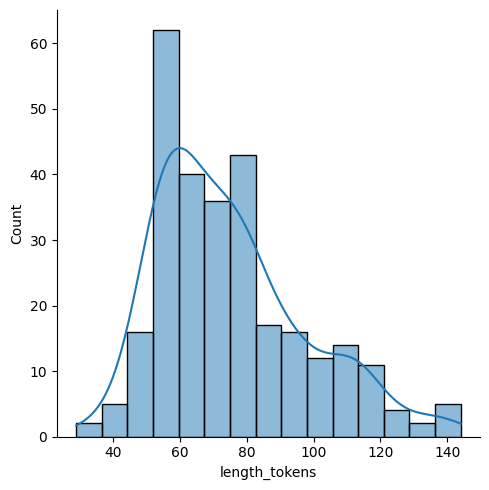

In [ ]:
import seaborn as sns

#create histogram with density curve overlaid
sns.displot(feats_table["length_tokens"], kde=True, bins=15)

In [ ]:
short_paragraphs = feats_table[feats_table["length_tokens"] <= 50]
print(short_paragraphs.shape)
print(len(short_paragraphs))

y_short = short_paragraphs["complexity_mean"]
X_short = short_paragraphs.drop(columns=["paragraph", "complexity_mean", "length_tokens"])
X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(X_short, y_short, test_size = 0.25, random_state=30)

(21, 21)
21


In [ ]:
med_paragraphs = feats_table[(feats_table["length_tokens"] > 50) & (feats_table["length_tokens"] <= 85)]
print(len(med_paragraphs))

y_med = med_paragraphs["complexity_mean"]
X_med = med_paragraphs.drop(columns=["paragraph", "complexity_mean", "length_tokens"])
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(X_med, y_med, test_size = 0.25, random_state=30)

189


In [ ]:
large_paragraphs = feats_table[feats_table["length_tokens"] > 85]
print(len(large_paragraphs))

y_large = large_paragraphs["complexity_mean"]
X_large = large_paragraphs.drop(columns=["paragraph", "complexity_mean", "length_tokens"])
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(X_large, y_large, test_size = 0.25, random_state=30)

75


In [ ]:
feat_names = ["noun", "verb", "adj", "adv", "part", "adv_part", "pron",
    "mean_height", "max_height", "mean_leaves", "parts_num",
    "mean_cosine_similarity", "mean_bert_score", "mean_intersection", "bert_true_pairs", "asl", "asw"]

In [ ]:
X_train_short_base, X_test_short_base = X_train_short[["asl", "asw"]], X_test_short[["asl", "asw"]]

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_short_base, y_train_short)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_short_base)
ridge_mse = mean_squared_error(y_test_short, y_pred)
print("Base res for short paragraphs Ridge mse = ", ridge_mse)
print()

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_short, y_train_short)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_short)
ridge_mse = mean_squared_error(y_test_short, y_pred)
print("short paragraphs Ridge mse = ", ridge_mse)
print()

coefs = ridge_regr.coef_
coefs = dict(zip(feat_names, coefs))
sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
# print(sorted_coefs)
for k, v in sorted_coefs:
  print(f"{k}: {v}")

Best score for Ridge in grid search: -0.5714846248111501
Best param: {'alpha': 0.01}
Base res for short paragraphs Ridge mse =  0.25588661069953095

Best score for Ridge in grid search: -0.8584456956100682
Best param: {'alpha': 10.0}
short paragraphs Ridge mse =  0.09661507117048647

verb: 0.1907546580721274
max_height: -0.08671166311672272
bert_true_pairs: -0.07512834419977256
mean_cosine_similarity: 0.06328773039610155
adv: 0.0625689372074236
adv_part: 0.0478521936069846
asl: -0.04724297013785273
part: -0.034127078487101004
parts_num: 0.034094531607766196
mean_bert_score: 0.01813133991566506
mean_height: -0.016650688203527695
adj: 0.013924804334110794
pron: -0.008749400199956542
asw: -0.004938970814080526
mean_intersection: 0.0044831805876981825
mean_leaves: -0.0030710521384362532
noun: -0.002146533604337364


In [ ]:
X_train_med_base, X_test_med_base = X_train_med[["asl", "asw"]], X_test_med[["asl", "asw"]]

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_med_base, y_train_med)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_med_base)
ridge_mse = mean_squared_error(y_test_med, y_pred)
print("Base res for medium paragraphs Ridge mse = ", ridge_mse)
print()

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_med, y_train_med)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_med)
ridge_mse = mean_squared_error(y_test_med, y_pred)
print("medium paragraphs Ridge mse = ", ridge_mse)
print()

coefs = ridge_regr.coef_
coefs = dict(zip(feat_names, coefs))
sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
# print(sorted_coefs)
for k, v in sorted_coefs:
  print(f"{k}: {v}")

Best score for Ridge in grid search: -0.3903274155440562
Best param: {'alpha': 2.154434690031882}
Base res for medium paragraphs Ridge mse =  0.42334453574785263

Best score for Ridge in grid search: -0.38838365208195713
Best param: {'alpha': 10.0}
medium paragraphs Ridge mse =  0.4130235229706025

mean_height: -0.16681714168726472
adv_part: 0.16522772054852133
mean_cosine_similarity: -0.12882903270129384
part: -0.09890803850796703
max_height: 0.09652149219668144
asl: -0.08626312447501984
asw: 0.06271313767171395
pron: 0.05625561629488
mean_bert_score: 0.051675017795974776
parts_num: -0.03938902913582889
mean_intersection: 0.032865892832538275
mean_leaves: -0.028670023159391916
adj: -0.024110359954921296
adv: -0.010847091721972447
bert_true_pairs: -0.0017850726425024338
verb: 0.0016112926801781819
noun: -0.0014976746589272017


In [ ]:
X_train_large_base, X_test_large_base = X_train_large[["asl", "asw"]], X_test_large[["asl", "asw"]]

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_large_base, y_train_large)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_large_base)
ridge_mse = mean_squared_error(y_test_large, y_pred)
print("Base res for large paragraphs Ridge mse = ", ridge_mse)
print()

ridge_regr = Ridge()
parameters = {"alpha": np.logspace(-2, 1, 10)}
ridge_clf = GridSearchCV(ridge_regr, parameters, scoring="neg_mean_squared_error")
ridge_clf.fit(X_train_large, y_train_large)

print(f"Best score for Ridge in grid search: {ridge_clf.best_score_}")
print(f"Best param: {ridge_clf.best_params_}")
ridge_regr = ridge_clf.best_estimator_

y_pred = ridge_regr.predict(X_test_large)
ridge_mse = mean_squared_error(y_test_large, y_pred)
print("large paragraphs Ridge mse = ", ridge_mse)
print()

coefs = ridge_regr.coef_
coefs = dict(zip(feat_names, coefs))
sorted_coefs = sorted(coefs.items(), key=lambda x: np.abs(x[1]), reverse=True)
# print(sorted_coefs)
for k, v in sorted_coefs:
  print(f"{k}: {v}")

Best score for Ridge in grid search: -0.568189324448338
Best param: {'alpha': 4.6415888336127775}
Base res for large paragraphs Ridge mse =  0.3106451779256967

Best score for Ridge in grid search: -0.6293298813452354
Best param: {'alpha': 10.0}
large paragraphs Ridge mse =  0.41467614496986355

bert_true_pairs: 0.15197676990608833
asl: 0.14718678258987863
pron: 0.1240800283321527
part: -0.12295786088179712
mean_height: 0.11379430952422073
parts_num: -0.08741209377121781
verb: 0.07520930992027912
adv_part: 0.06278038567194692
mean_cosine_similarity: -0.05034308728688517
mean_leaves: 0.037777704553428014
adj: -0.027640609576276925
adv: 0.01326896056228108
mean_bert_score: 0.012796259170643727
asw: 0.007787562121008819
max_height: 0.006445348134718262
mean_intersection: 0.005191668674715871
noun: -0.0027943723788020907


### Средние значения признаков

In [ ]:
feats_1 = feats_table.loc[round(feats_table["complexity_mean"]) == 1].drop("paragraph", axis=1)
print(feats_1.shape)
feats_1.mean()

(41, 20)


Unnamed: 0                164.170732
complexity_mean             1.186992
length_tokens              59.878049
noun                        6.219512
verb                        1.474971
adj                         2.348664
adv                         0.700232
part                        0.794483
adv_part                    0.037805
pron                        0.545761
mean_height                 5.919628
max_height                  7.585366
mean_leaves                 7.881475
parts_num                   0.907898
mean_cosine_similarity      0.402069
mean_bert_score             0.663645
mean_intersection           2.156504
bert_true_pairs             0.569919
asl                        15.879094
asw                         6.933101
dtype: float64

In [ ]:
feats_2 = feats_table.loc[round(feats_table["complexity_mean"]) == 2].drop("paragraph", axis=1)
print(feats_2.shape)
feats_2
feats_2.mean()

(124, 20)


Unnamed: 0                142.112903
complexity_mean             1.997312
length_tokens              71.685484
noun                        7.353139
verb                        1.549514
adj                         2.774946
adv                         0.795187
part                        1.130581
adv_part                    0.031528
pron                        0.520811
mean_height                 6.484277
max_height                  8.411290
mean_leaves                 9.484962
parts_num                   0.983733
mean_cosine_similarity      0.440219
mean_bert_score             0.663472
mean_intersection           2.334389
bert_true_pairs             0.762078
asl                        18.587094
asw                         7.153145
dtype: float64

In [ ]:
feats_3 = feats_table.loc[round(feats_table["complexity_mean"]) == 3].drop("paragraph", axis=1)
print(feats_3.shape)

feats_3.mean()

(98, 20)


Unnamed: 0                139.336735
complexity_mean             2.921769
length_tokens              82.479592
noun                        8.866229
verb                        1.586548
adj                         3.053729
adv                         0.755491
part                        1.454341
adv_part                    0.059111
pron                        0.461710
mean_height                 7.103057
max_height                  9.204082
mean_leaves                10.554491
parts_num                   0.968886
mean_cosine_similarity      0.461931
mean_bert_score             0.668512
mean_intersection           2.705709
bert_true_pairs             0.787132
asl                        21.342003
asw                         7.267646
dtype: float64

In [ ]:
feats_4 = feats_table.loc[round(feats_table["complexity_mean"]) == 4].drop("paragraph", axis=1)
print(feats_4.shape)

feats_4.mean()

(20, 20)


Unnamed: 0                121.050000
complexity_mean             3.783333
length_tokens              86.300000
noun                       10.195556
verb                        1.443889
adj                         3.779444
adv                         0.631111
part                        1.455556
adv_part                    0.064167
pron                        0.488889
mean_height                 7.116667
max_height                  8.800000
mean_leaves                11.393333
parts_num                   0.939722
mean_cosine_similarity      0.545212
mean_bert_score             0.694338
mean_intersection           4.315000
bert_true_pairs             0.881250
asl                        23.185278
asw                         7.541952
dtype: float64

In [ ]:
feats_5 = feats_table.loc[round(feats_table["complexity_mean"]) == 5].drop("paragraph", axis=1)
print(feats_5.shape)

feats_5.mean()

(2, 20)


Unnamed: 0                 20.500000
complexity_mean             4.833333
length_tokens             114.000000
noun                        9.775000
verb                        1.650000
adj                         5.300000
adv                         0.650000
part                        1.825000
adv_part                    0.100000
pron                        0.850000
mean_height                 8.075000
max_height                 11.500000
mean_leaves                12.425000
parts_num                   0.675000
mean_cosine_similarity      0.538529
mean_bert_score             0.685878
mean_intersection           4.291667
bert_true_pairs             0.875000
asl                        25.650000
asw                         7.671053
dtype: float64